# DeepLabv3 transfer learning implementation


## Import pretrained model Deeplabv3

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torch
import os

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

%matplotlib widget

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.AlexNet_DeepLab import AlexNetDeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from ModelBuilder.DenseNet201_DeepLab import DenseNet201DeepLab
from ModelBuilder.InceptionV3_DeepLab import InceptionV3DeepLab
from ModelBuilder.ConvNeXt_DeepLab import ConvNeXtDeepLab
from ModelBuilder.ClassifierHead import DeepLabHead


In [2]:
transform_image = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias = True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])
transform_mask = transforms.Compose(
    [
     transforms.ToTensor()
     ])

path = 'G:/MachineLearning/liver-database/'
save_path = 'G:/MachineLearning/models/'
#path = 'segmentations/'
dataset_learn = LiverDataset(path + 'validation/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_learn = torch.utils.data.DataLoader(dataset_learn, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

dataset_test = LiverDataset(path + 'testing/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_test = torch.utils.data.DataLoader(dataset_learn, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

## Vizualizam o imagine din dataset

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to C:\Users\Stanciu/.cache\torch\hub\checkpoints\convnext_large-ea097f82.pth
100.0%


torch.Size([512, 512])
tensor(1.)


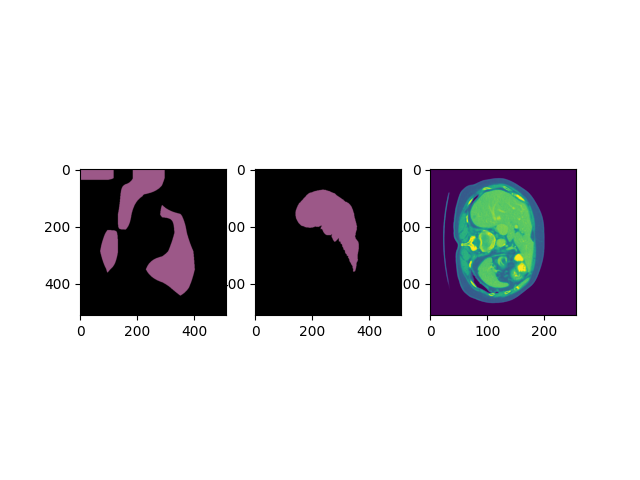

In [3]:
model_checkpoint = 'G:/MachineLearning/models/ResNeXt101/ResNeXt101_checkpoint.pt'
model = ConvNeXtDeepLab()
# checkpoint = torch.load(model_checkpoint)
# model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cpu')
model.to(device)

model.eval()
input_tensor, mask = dataset_learn.__getitem__(60)
input_batch = input_tensor.repeat(2, 1, 1, 1)
pred = model(input_batch.to(device))

final_func = nn.Sigmoid()
pred = final_func(pred).squeeze()
pred = torch.nn.functional.interpolate(pred.unsqueeze(0), size=512, mode="bilinear", align_corners=False).squeeze()
output_predictions = torch.round(pred[0])

print(output_predictions.shape)
output_predictions = output_predictions.detach().squeeze()
output_predictions = np.round(output_predictions)
mask = mask.cpu().squeeze()

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(3)])[:, None] * 1.1 * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy())
r.putpalette(colors)

r_mask = Image.fromarray(mask.byte().cpu().numpy())
r_mask.putpalette(colors)

print(torch.max(output_predictions))
plt.subplot(1, 3, 1)
plt.imshow(r)
plt.subplot(1, 3, 2)
plt.imshow(r_mask)
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(input_tensor.numpy()))
plt.show()



In [4]:
loss_fn = DiceLoss()
print(1.0 - loss_fn(output_predictions, mask))

tensor(0.2889)
